In [1]:
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from skorch import NeuralNetRegressor
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np
import torch

In [2]:
ROOT_PATH = '/home/jovyan/TIL/'
DATA_PATH = f'{ROOT_PATH}/dataset/KBO'

EPOCHS = 10
LR     = 1e-3
BS     = 32

<AxesSubplot: >

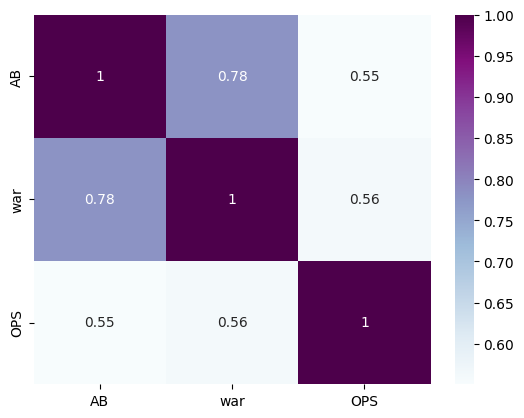

In [3]:
csv    = pd.read_csv(f'{DATA_PATH}/kbo_train.csv')
labels = csv['YOPS']
inputs = csv.drop(['age', 'salary', 'hand2', 'cp', 'YOPS', 'YAB'], axis = 1)
sns.heatmap(inputs.corr(), annot = True, cmap = 'BuPu')

In [4]:
inputs = inputs.to_numpy()
labels = labels.to_numpy().reshape((-1, 1))

In [5]:
scaler = MinMaxScaler()

scaler.fit(inputs)
inputs = scaler.transform(inputs)

scaler.fit(labels)
labels = scaler.transform(labels)

In [6]:
class ModelBuilder(nn.Module):
    
    def __init__(self):
        
        super(ModelBuilder, self).__init__()
        self.fc1     = nn.Linear( 3,  15, bias = True, dtype = torch.float32)
        self.fc2     = nn.Linear(15,  30, bias = True, dtype = torch.float32)
        self.fc3     = nn.Linear(30,  10, bias = True, dtype = torch.float32)
        self.fc4     = nn.Linear(10,   1, bias = True, dtype = torch.float32)    
        self.dropout = nn.Dropout(0.2)
        
    
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        return F.relu(self.fc4(x))

In [7]:
sk_model  = NeuralNetRegressor(
                ModelBuilder,
                criterion = nn.MSELoss,
            )

param_grid = {
                'optimizer'           : [optim.SGD, optim.RMSprop, optim.Adagrad, optim.Adam, optim.NAdam],
                'batch_size'          : [8, 16, 32, 64, 128],
                'max_epochs'          : [5, 10, 15, 30, 50],
                'optimizer__lr'       : [1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
            }

In [8]:
inputs = inputs.astype(np.float32)
labels = labels.astype(np.float32)

In [ ]:
grid        = GridSearchCV(estimator = sk_model, param_grid = param_grid, n_jobs = 1, cv = 3)
grid_result = grid.fit(inputs, labels)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1209        0.1210  0.6560
      2        0.1209        0.1210  0.3751
      3        0.1209        0.1210  0.3464
      4        0.1209        0.1210  0.3458
      5        0.1209        0.1210  0.2926
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1307        0.1388  0.2706
      2        0.1307        0.1388  0.1922
      3        0.1307        0.1388  0.1731
      4        0.1307        0.1388  0.1866
      5        0.1307        0.1388  0.1842
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1124        0.1112  0.1834
      2        0.0752        0.0691  0.1768
      3        0.0470        0.0447  0.1719
      4        0.0299        0.0310  0.1720
      5        0.0223        0.0233  0.1687
  epoch    train_loss    valid_loss     dur
-------  ------------  ---------